In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
import pymc3 as pm
import time
from pymc3 import glm
import seaborn as sns
import gzip
import datetime
import csv
import statsmodels.api as sm
pd.options.mode.chained_assignment = None
import arviz as az

# Research Question 1: Bayesian Hierarchical Modeling
Quantifying the effects of COVID-19 on recreation/retail activites in Alameda County

In [2]:
google_ca = pd.read_csv("google_ca_mobility_data.csv")

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# User defined functions used to create the open_status variable
def opening_day(dates):
    '''
    Function used to create a binary variable to indicate whether a certain day is after the official
    reopening date in the State of California (June 15, 2021)
    -----
    Input:
    
    dates (NumPy arr) - NumPy array of dates in YYYY-MM-DD format
    -----
    Output:
    
    open_status (NumPy arr) - Boolean NumPy array indicating whether the corresponding
                              row is after the official opening date
    '''
    datetime_conversions = np.array([datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates])
    opening_day = datetime.datetime.strptime('2021-06-15', '%Y-%m-%d')
    open_status = datetime_conversions > opening_day
    return open_status

def calculate_metrics(counties):
    '''
    Function that calculates the difference in mean mobility score for the specified county
    -----
    Inputs:
    
    counties (NumPy arr) - NumPy array with names of each California county to calculate
                           difference in mean mobility score; the values must include "County"
                           Ex. "Alameda County", "Contra Costa County"
    -----
    Output:
    
    metrics (NumPy arr) - NumPy array with the calculated metrics
    -----
    '''
    metrics = np.array([])
    for county in counties:
        county_df = google_ca.query('sub_region_2 == @county')
        below_df = county_df[county_df['open_status'] == False]
        after_df = county_df[county_df['open_status'] == True]
        closed_mean = np.mean(below_df['retail_and_recreation_percent_change_from_baseline'])
        open_mean = np.mean(after_df['retail_and_recreation_percent_change_from_baseline'])
        metric = open_mean - closed_mean
        metrics = np.append(metric, metrics)
    return metrics

In [4]:
# Create Alameda County dataframe

alameda = google_ca.query('sub_region_2 == "Alameda County"')
alameda['open_status'] = opening_day(alameda['date'].values)

alameda.head()

,Unnamed: 0,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,open_status
974,9254418,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-15,1.0,0.0,22.0,1.0,0.0,-1.0,False
975,9254419,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-16,7.0,0.0,24.0,5.0,1.0,-2.0,False
976,9254420,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-17,13.0,1.0,55.0,-31.0,-53.0,11.0,False
977,9254421,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-18,-2.0,3.0,21.0,3.0,0.0,0.0,False
978,9254422,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,2020-02-19,-1.0,0.0,14.0,1.0,0.0,0.0,False


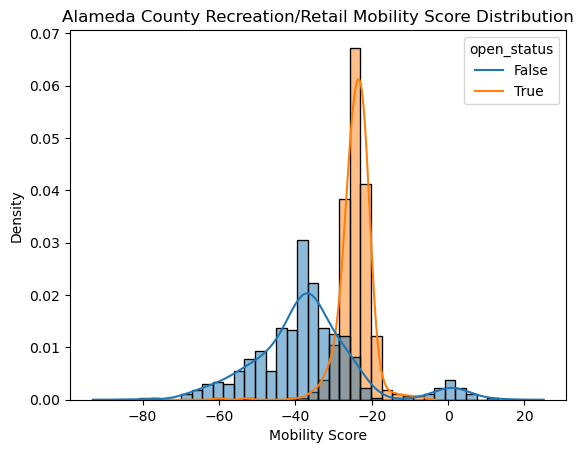

In [5]:
sns.histplot(data=alameda,
             x='retail_and_recreation_percent_change_from_baseline',
             stat='density',
             hue='open_status')
sns.kdeplot(data=alameda,
            x='retail_and_recreation_percent_change_from_baseline',
            hue='open_status')
plt.title('Alameda County Recreation/Retail Mobility Score Distribution')
plt.xlabel('Mobility Score')
plt.savefig('Alameda County Score Distribution')
plt.show()

In [6]:
# Calculate and print descriptive statistics
new_normal_mean = np.mean(alameda.query('open_status == True')['retail_and_recreation_percent_change_from_baseline'])
covid_mean = np.mean(alameda.query('open_status != True')['retail_and_recreation_percent_change_from_baseline'])
sd_likelihood = np.std(alameda['retail_and_recreation_percent_change_from_baseline'])
sd_new_normal = np.std(alameda.query('open_status == True')['retail_and_recreation_percent_change_from_baseline'])
sd_covid = np.std(alameda.query('open_status != True')['retail_and_recreation_percent_change_from_baseline'])
print(f'COVID Mean: {covid_mean}')
print(f'COVID SD: {sd_covid}')
print(f'New Normal Mean: {new_normal_mean}')
print(f'New Normal SD: {sd_new_normal}')

COVID Mean: -37.14168377823409
COVID SD: 13.837961047545692
New Normal Mean: -24.29158110882957
New Normal SD: 4.826049158214988


In [7]:
# Filter Alameda County data by open_status
alameda_closed = alameda.query('open_status != True')
alameda_open = alameda.query('open_status == True')

In [8]:
# PyMC3 model for mu_0

pi = 0.5      # Bernoulli hyperparameter
sigma = 10    # SD of likelihood
mu_0 = -37    # Mean of prior
sigma_0 = 14  # SD of prior

with pm.Model() as model_mobility_scores:
    z = pm.Bernoulli('z', p=pi)
    mu_pre = pm.Normal('mu_pre', mu=mu_0, sigma=sigma_0)
    X = pm.Normal('X', mu=mu_pre, sigma=sigma, observed=alameda_closed['retail_and_recreation_percent_change_from_baseline'])
    
    mu_0_trace = pm.sample(2000, chains=2, tune=10000, return_inferencedata=True, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [z]
>NUTS: [mu_pre]


Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 15 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


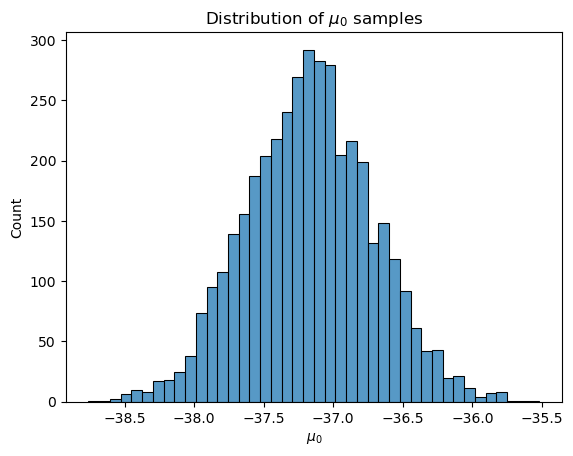

In [9]:
# Plot samples from mu_0 posterior distribution
mu_pre_samples = mu_0_trace['posterior']['mu_pre'].data.flatten()
sns.histplot(data=mu_pre_samples)
plt.xlabel('$\mu_0$')
plt.title('Distribution of $\mu_0$ samples')
plt.show()

In [10]:
# PyMC3 model for mu_1

pi = 0.5      # Bernoulli hyperparameter
sigma = 10    # SD of likelihood
mu_1 = -24    # Mean of prior
sigma_1 = 5   # SD of prior

with pm.Model() as model_mobility_scores:
    z = pm.Bernoulli('z', p=pi)
    mu_post = pm.Normal('mu_post', mu=mu_1, sigma=sigma_1)
    X = pm.Normal('X', mu=mu_post, sigma=sigma, observed=alameda_open['retail_and_recreation_percent_change_from_baseline'])
    
    mu_1_trace = pm.sample(2000, chains=2, tune=10000, return_inferencedata=True, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [z]
>NUTS: [mu_post]


Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 13 seconds.


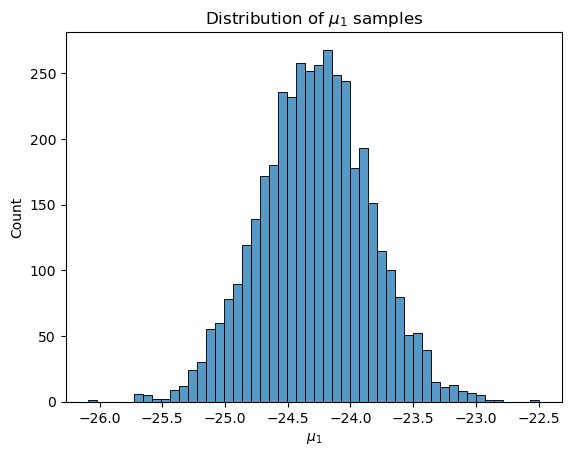

In [11]:
# Plot samples from mu_1 posterior distribution
mu_post_samples = mu_1_trace['posterior']['mu_post'].data.flatten()
sns.histplot(data=mu_post_samples)
plt.xlabel('$\mu_1$')
plt.title('Distribution of $\mu_1$ samples')
plt.show()

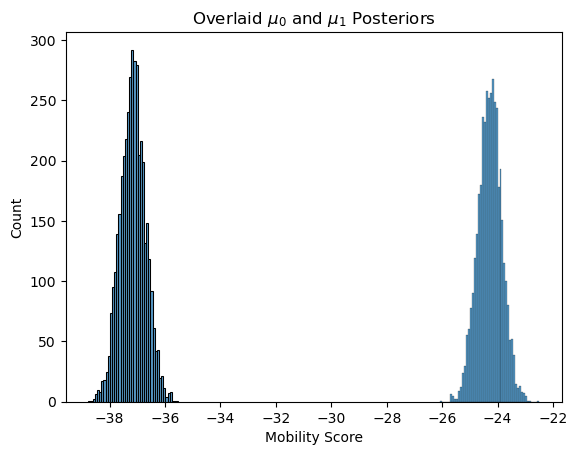

In [12]:
# Plot both posteriors together
sns.histplot(data=mu_pre_samples)
sns.histplot(data=mu_post_samples)
plt.xlabel('Mobility Score') # this represents the mu_0 and mu_1 samples genered by the NUTS sampler
plt.title('Overlaid $\mu_0$ and $\mu_1$ Posteriors')
plt.show()

In [13]:
# Calculate difference in means
closed_mean = np.mean(mu_pre_samples)
open_mean = np.mean(mu_post_samples)
diff_in_means = open_mean - closed_mean
print(f'Differnce in means: {diff_in_means}')

Differnce in means: 12.88361632382096


# Research Question 2: Causal Inference
How do high vaccine rates in a county affect average mobility scores?

In [14]:
covid = pd.read_csv("ca_covid_county.csv")

In [15]:
pop = pd.read_csv("population_2020.csv").T

In [16]:
education = pd.read_csv("education.csv")

In [17]:
income = pd.read_csv("income.csv").T

In [18]:
# https://fred.stlouisfed.org/release/tables?rid=430&eid=326943&od=#
# in order of county w/0 alphine and sierra
median_age = np.array([38.0, 49.7, 36.6, 52.3, 35.6, 39.9, 40.1, 46.2, 32.6, 35.5, 39.1, 32.5, 44.5, 32.1, 32.1, 44.6, 37.3, 37.0, 34.3, 47.1, 51.6,
                      43.6, 31.3, 47.8, 40.3, 34.9, 42.1, 50.1, 38.5, 42.1, 51.8, 36.0, 36.6, 35.7, 33.8, 36.3, 38.7, 34.6, 39.7, 40.0, 33.9, 37.5,
                      38.5, 41.5, 47.1, 38.5, 42.5, 34.4, 35.8, 40.0, 53.9, 31.3, 48.6, 38.7, 31.5, 33.2])

In [19]:
income = income[income.index.str.contains("County, California!!Households!!Estimate")] 
income = income.drop(["Alpine County, California!!Households!!Estimate", "Sierra County, California!!Households!!Estimate"])
income = income[11].str.replace(',', '').astype(int).values

In [20]:
pop = pop.iloc[1:,:][[0, 2]]
pop = pop.reset_index()
pop = pop.rename(columns={"index": "county", 0: "population", 2: "white"})
pop["county"] = pop["county"].str[:-19]
pop = pop.drop([1, 45])  #drop alpine and sierra county
pop["population"] = pop["population"].str.replace(',', '').astype(int)
pop["white"] = pop["white"].str.replace(',', '').astype(int)
pop.head()

,county,population,white
0,Alameda,1682353,523836
2,Amador,40474,31104
3,Butte,211632,149557
4,Calaveras,45292,36315
5,Colusa,21839,9364


In [21]:
education = education.T
education.columns = education.iloc[0]
education = education[education.index.str.contains("Total!!Estimate")]
education = education.drop(["Alpine County, California!!Total!!Estimate", "Sierra County, California!!Total!!Estimate"])
bachelor_count = education.iloc[:,5].str.replace(',', '').astype(int).values + education.iloc[:,15].str.replace(',', '').astype(int).values

In [22]:
pop["median_age"] = median_age
pop["white_perc"] = pop["white"] / pop["population"]
pop.head()

,county,population,white,median_age,white_perc
0,Alameda,1682353,523836,38.0,0.311371
2,Amador,40474,31104,49.7,0.768493
3,Butte,211632,149557,36.6,0.706684
4,Calaveras,45292,36315,52.3,0.801797
5,Colusa,21839,9364,35.6,0.428774


In [23]:
def after_day_x(dates, date):
    datetime_conversions = np.array([datetime.datetime.strptime(d, '%Y-%m-%d') for d in dates])
    starting_date = datetime.datetime.strptime(date, '%Y-%m-%d')
    after = datetime_conversions > starting_date
    return after

In [24]:
google_ca["after_01/01/2022"] = after_day_x(google_ca["date"], '2022-01-01')

In [25]:
start_2022 = google_ca[google_ca["after_01/01/2022"]==True]

In [26]:
avg_mobility = start_2022.groupby("sub_region_2").mean()["retail_and_recreation_percent_change_from_baseline"].values

In [27]:
vaccine_status_jan_01_2022 = covid[covid["administered_date"] == "2022-01-01"][2:][["county", "cumulative_fully_vaccinated"]]
vaccine_status_jan_01_2022 = vaccine_status_jan_01_2022.drop([2385, 8667, 11248, 12086]) #drop alpine, sierra, outside california, unknown
vaccine_status_jan_01_2022.head()

,county,cumulative_fully_vaccinated
12958,Alameda,1301552
14143,Amador,21246
15002,Butte,111861
15862,Calaveras,23632
16698,Colusa,12235


In [28]:
percentage = pop.merge(vaccine_status_jan_01_2022)
percentage["avg_mobility"] = avg_mobility
percentage["vac_percentage"] = percentage["cumulative_fully_vaccinated"] / percentage["population"]
percentage["bachelor_perc"] = bachelor_count / percentage["population"]
percentage["income"] = income
percentage.head()

,county,population,white,median_age,white_perc,cumulative_fully_vaccinated,avg_mobility,vac_percentage,bachelor_perc,income
0,Alameda,1682353,523836,38.0,0.311371,1301552,-25.397213,0.773650,0.356089,104888
1,Amador,40474,31104,49.7,0.768493,21246,3.216028,0.524930,0.137693,65187
2,Butte,211632,149557,36.6,0.706684,111861,-14.916376,0.528564,0.213323,54972
3,Calaveras,45292,36315,52.3,0.801797,23632,2.616725,0.521770,0.158549,67054
4,Colusa,21839,9364,35.6,0.428774,12235,5.434164,0.560236,0.094510,59427


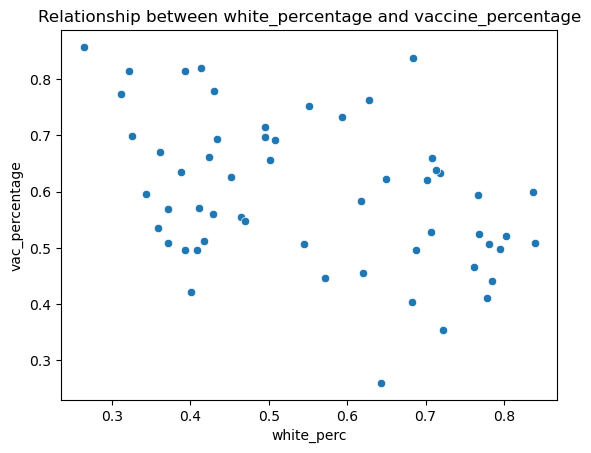

In [29]:
sns.scatterplot(data=percentage, x="white_perc", y="vac_percentage")
plt.title("Relationship between white_percentage and vaccine_percentage");

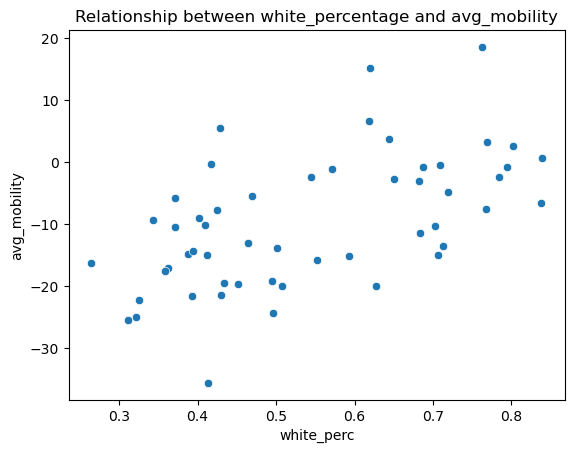

In [30]:
sns.scatterplot(data=percentage, x="white_perc", y="avg_mobility")
plt.title("Relationship between white_percentage and avg_mobility");

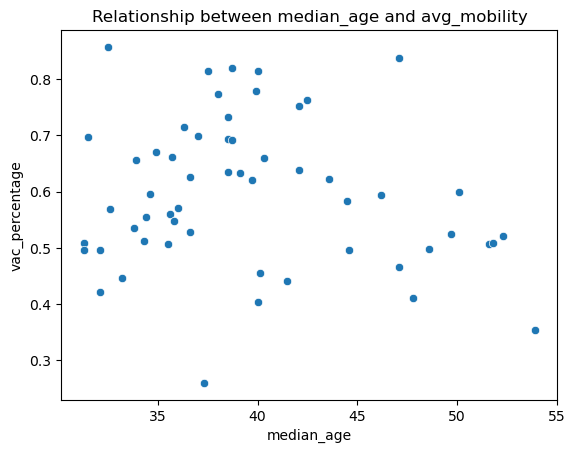

In [31]:
sns.scatterplot(data=percentage, x="median_age", y="vac_percentage")
plt.title("Relationship between median_age and avg_mobility");

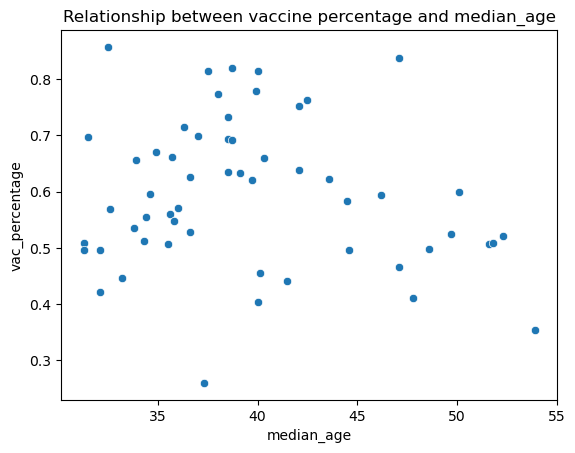

In [32]:
sns.scatterplot(data=percentage, x="median_age", y="vac_percentage")
plt.title("Relationship between vaccine percentage and median_age");

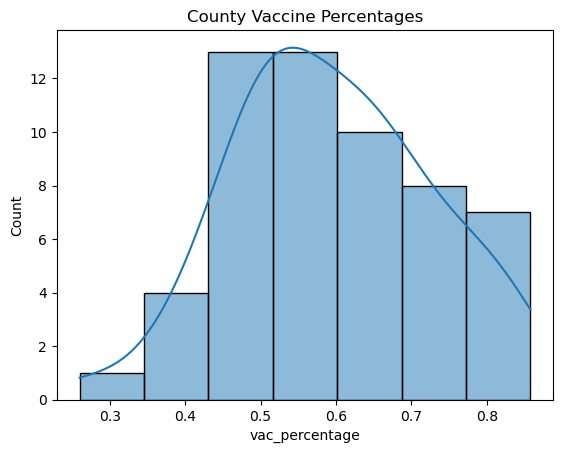

In [33]:
sns.histplot(percentage["vac_percentage"], kde=True)
plt.title("County Vaccine Percentages");

In [34]:
percentage["high_vac"] = (percentage["vac_percentage"] > 0.55).astype(int)
percentage.head()

,county,population,white,median_age,white_perc,cumulative_fully_vaccinated,avg_mobility,vac_percentage,bachelor_perc,income,high_vac
0,Alameda,1682353,523836,38.0,0.311371,1301552,-25.397213,0.773650,0.356089,104888,1
1,Amador,40474,31104,49.7,0.768493,21246,3.216028,0.524930,0.137693,65187,0
2,Butte,211632,149557,36.6,0.706684,111861,-14.916376,0.528564,0.213323,54972,0
3,Calaveras,45292,36315,52.3,0.801797,23632,2.616725,0.521770,0.158549,67054,0
4,Colusa,21839,9364,35.6,0.428774,12235,5.434164,0.560236,0.094510,59427,1


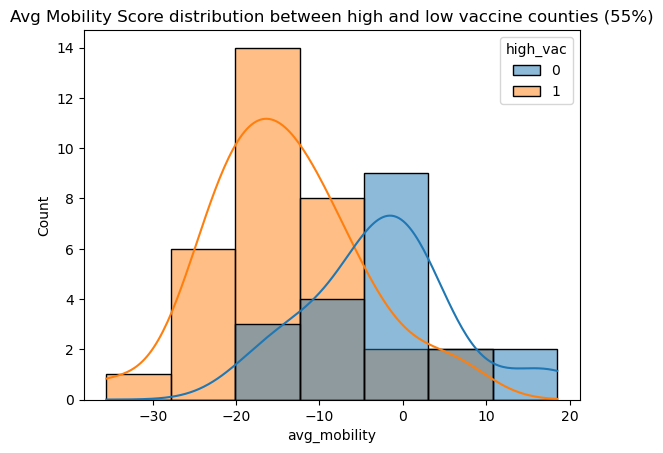

In [35]:
sns.histplot(data=percentage, x="avg_mobility", hue="high_vac", kde=True)
plt.title("Avg Mobility Score distribution between high and low vaccine counties (55%)");

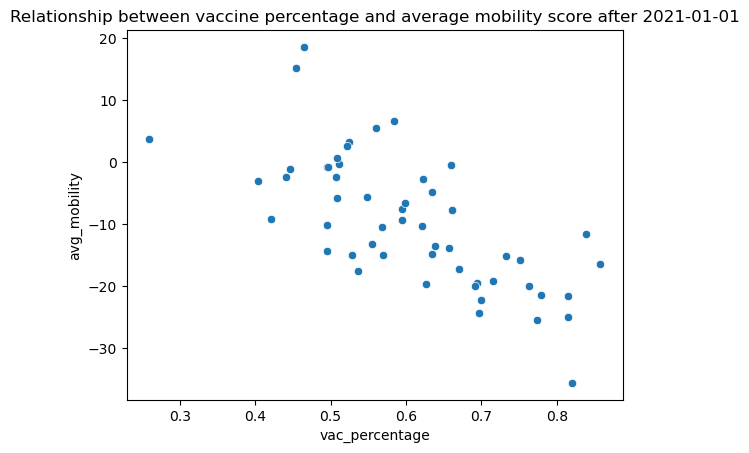

In [36]:
sns.scatterplot(data=percentage, x="vac_percentage", y="avg_mobility")
plt.title("Relationship between vaccine percentage and average mobility score after 2021-01-01");

In [37]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [38]:
#drop 3 more counties that have NA data for mobility after 01-01-2022
percentage = percentage.drop([20, 23, 50]) #Mariposa, Modoc, Trinity

In [39]:
linear_model = fit_OLS_model(percentage, 'avg_mobility', ['high_vac'])
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           avg_mobility   R-squared (uncentered):                   0.614
Model:                            OLS   Adj. R-squared (uncentered):              0.607
Method:                 Least Squares   F-statistic:                              82.82
Date:                Mon, 08 May 2023   Prob (F-statistic):                    2.43e-12
Time:                        12:38:28   Log-Likelihood:                         -190.92
No. Observations:                  53   AIC:                                      383.8
Df Residuals:                      52   BIC:                                      385.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [40]:
linear_model = fit_OLS_model(percentage, 'avg_mobility', ['high_vac', 'median_age', "white_perc", "bachelor_perc", "income"])
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           avg_mobility   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.792
Method:                 Least Squares   F-statistic:                              41.30
Date:                Mon, 08 May 2023   Prob (F-statistic):                    2.90e-16
Time:                        12:38:28   Log-Likelihood:                         -171.96
No. Observations:                  53   AIC:                                      353.9
Df Residuals:                      48   BIC:                                      363.8
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [41]:
predict = linear_model.predict(percentage[['high_vac', 'median_age', "white_perc", "bachelor_perc", "income"]])

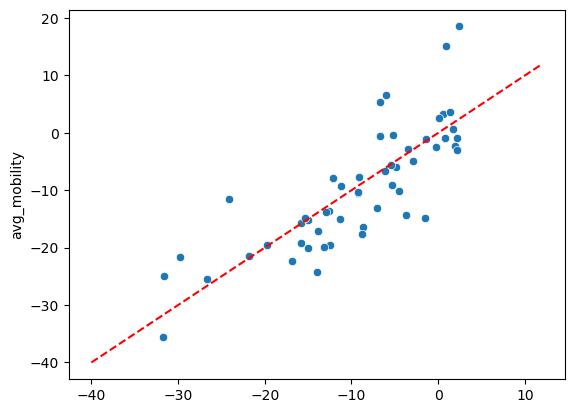

In [42]:
sns.scatterplot(x=predict, y=percentage["avg_mobility"])
x = np.linspace(-40, 12, 1000)
plt.plot(x, x, '--r');

In [43]:
def draw_tau_hat(data, random_state=None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output 
        for grading and troubleshooting purposes
    Output:
        float, estimated average treatment effect
    """
    sample = data.sample(n=len(data), random_state=random_state, replace=True)
    fit_model = fit_OLS_model(sample, 'avg_mobility', ['high_vac', 'median_age', "white_perc", "bachelor_perc", "income"])
    estimated_ate = fit_model.params['high_vac']
    return estimated_ate

In [44]:
def get_bootstrapped_ate(data, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimates.append(draw_tau_hat(data))
    return estimates

In [45]:
ates = get_bootstrapped_ate(percentage, 1000)
confidence_interval = [np.percentile(ates, 2.5), 
                       np.percentile(ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0])} to {np.round(confidence_interval[1])}")

Our 95% confidence interval ranges from -8.0 to 2.0


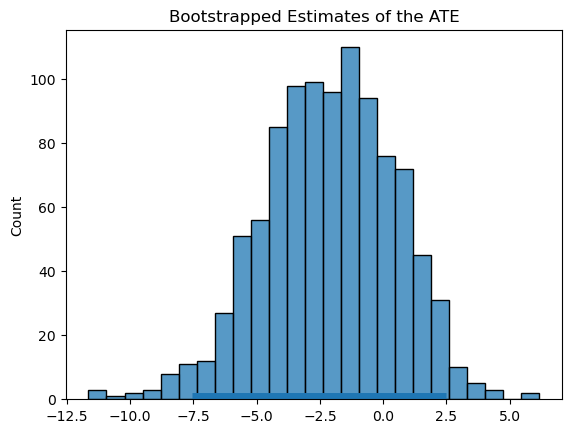

In [46]:
sns.histplot(ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE");

### Aditional EDA

In [47]:
percentage["bachelor_high"] = (percentage["bachelor_perc"] > 0.2).astype(int)

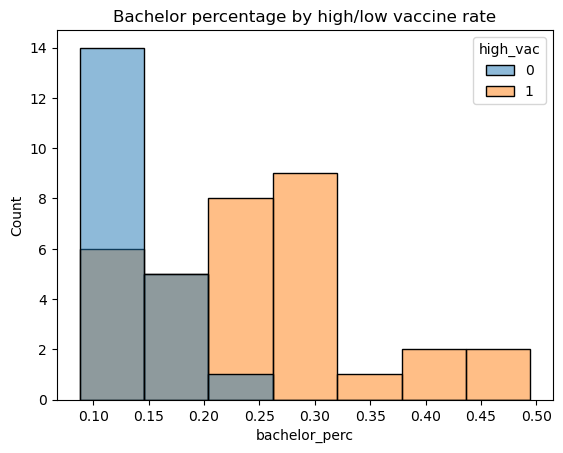

In [48]:
sns.histplot(data=percentage, x="bachelor_perc", hue="high_vac");
plt.title("Bachelor percentage by high/low vaccine rate");

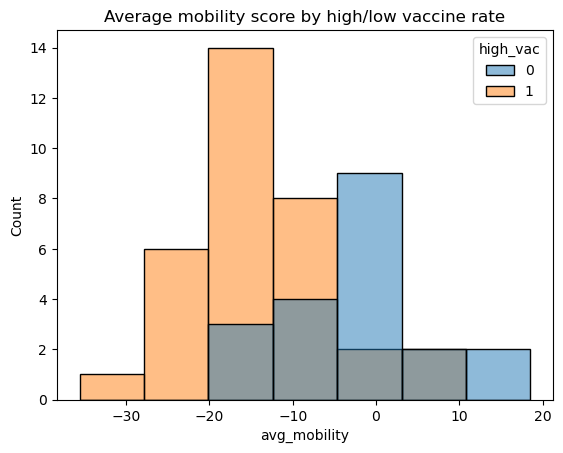

In [49]:
sns.histplot(data=percentage, x="avg_mobility", hue="high_vac");
plt.title("Average mobility score by high/low vaccine rate");

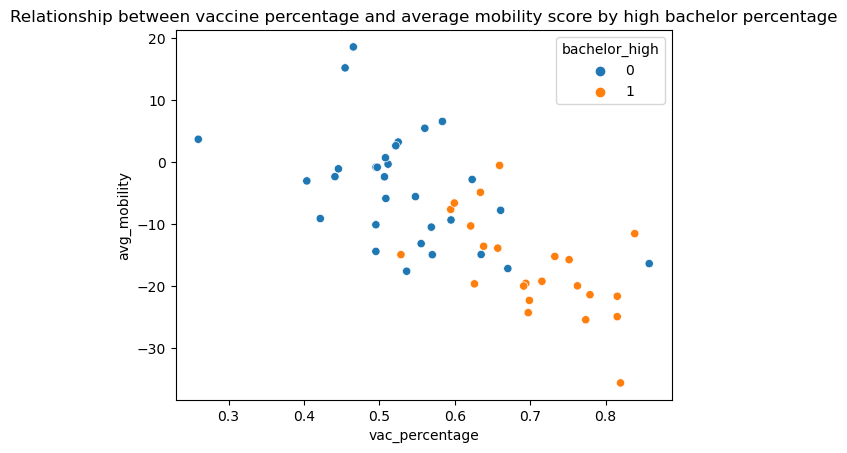

In [50]:
sns.scatterplot(data=percentage, x="vac_percentage", y="avg_mobility", hue="bachelor_high")
plt.title("Relationship between vaccine percentage and average mobility score by high bachelor percentage");

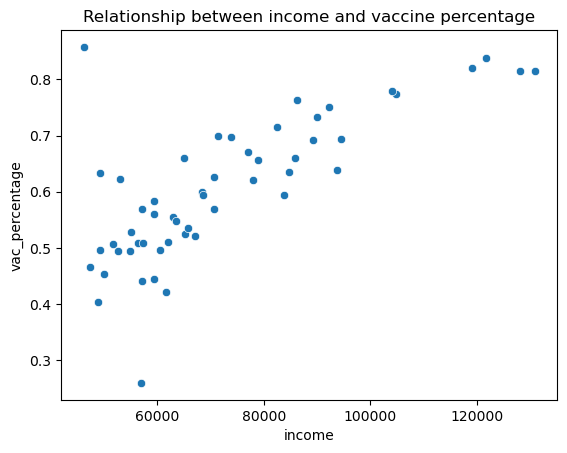

In [51]:
sns.scatterplot(data=percentage, x="income", y="vac_percentage");
plt.title("Relationship between income and vaccine percentage");

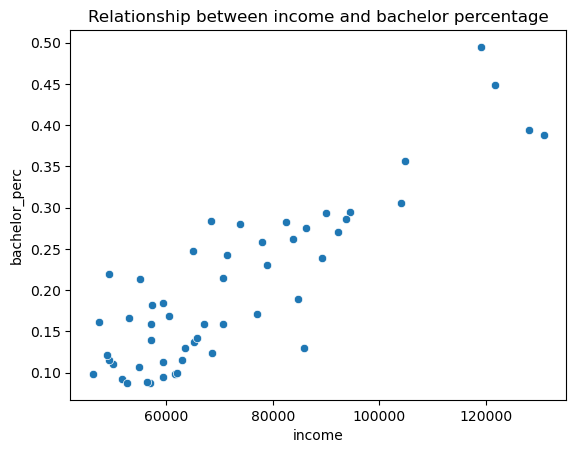

In [52]:
sns.scatterplot(data=percentage, x="income", y="bachelor_perc");
plt.title("Relationship between income and bachelor percentage");